In [347]:
!pip install sklearn

In [348]:
import pandas as pd
import numpy as np
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
import re
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [349]:
DATASET_COLUMNS=['tweet_text','emotion_in_tweet_is_directed_at','is_there_an_emotion_directed_at_a_brand_or_product']
DATASET_ENCODING = "ISO-8859-1"
df=pd.read_csv('/content/judge-1377884607_tweet_product_company.csv',encoding=DATASET_ENCODING)

In [350]:
df.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [351]:
df.columns

Index(['tweet_text', 'emotion_in_tweet_is_directed_at',
       'is_there_an_emotion_directed_at_a_brand_or_product'],
      dtype='object')

In [352]:
len(df)

9093

In [353]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [354]:
np.sum(df.isnull().any(axis=1))

5802

In [355]:
np.sum(df.notnull().any(axis=1))

9093

In [356]:
df["emotion_in_tweet_is_directed_at"].fillna("No product", inplace = True)

In [357]:
np.sum(df["tweet_text"].isnull())

1

In [358]:
# for i in range(len(df)):
#   if(df.loc[i,"tweet_text"].isnull()==True):
#     print(i)
#     break;
df[df['tweet_text'].isnull()].index.tolist()

[6]

In [359]:
df=df.dropna()
np.sum(df["tweet_text"].isnull())

0

In [360]:
np.sum(df.notnull())

tweet_text                                            9092
emotion_in_tweet_is_directed_at                       9092
is_there_an_emotion_directed_at_a_brand_or_product    9092
dtype: int64

In [361]:
df["is_there_an_emotion_directed_at_a_brand_or_product"].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

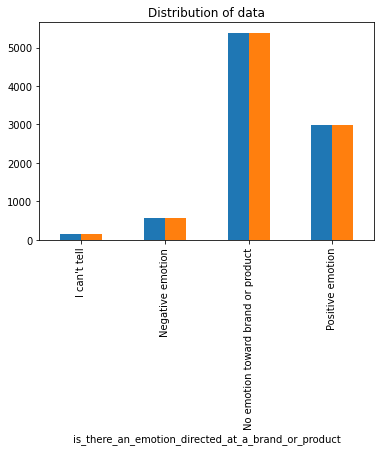

In [362]:
x=df.groupby('is_there_an_emotion_directed_at_a_brand_or_product').count().plot(kind='bar', title='Distribution of data',legend=False)
# x.set_xticklabels(['Negative emotion', 'Positive emotion',
#        'No emotion toward brand or product', "I can't tell"],rotation=0)
#x

In [363]:
text,sentiments = list(df["tweet_text"]),list(df["is_there_an_emotion_directed_at_a_brand_or_product"])

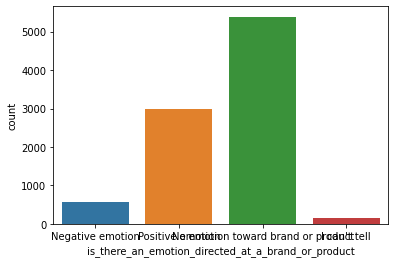

In [364]:
import seaborn as sns
sns.countplot(x='is_there_an_emotion_directed_at_a_brand_or_product', data=df)

In [365]:
data=df[['tweet_text','is_there_an_emotion_directed_at_a_brand_or_product']]

In [366]:
data=data.rename(columns={'tweet_text':'text','is_there_an_emotion_directed_at_a_brand_or_product':'sentiments'})

In [367]:
data['sentiments'].unique()

array(['Negative emotion', 'Positive emotion',
       'No emotion toward brand or product', "I can't tell"], dtype=object)

In [368]:
data_pos=data[data['sentiments'] == 'Positive emotion']
data_neg=data[data['sentiments'] == 'Negative emotion']
data_neutral=data[data['sentiments'] == 'No emotion toward brand or product']
data_dknow=data[data['sentiments'] == 'I can\'t tell']

In [369]:
data['text']=data['text'].str.lower()
data['text'].head(3)

0    .@wesley83 i have a 3g iphone. after 3 hrs twe...
1    @jessedee know about @fludapp ? awesome ipad/i...
2    @swonderlin can not wait for #ipad 2 also. the...
Name: text, dtype: object

In [370]:
data.reset_index()
data['text'].iloc[6]

'#sxsw is just starting, #ctia is around the corner and #googleio is only a hop skip and a jump from there, good time to be an #android fan'

In [371]:
data['text'][0]

'.@wesley83 i have a 3g iphone. after 3 hrs tweeting at #rise_austin, it was dead!  i need to upgrade. plugin stations at #sxsw.'

In [372]:

# for i in range(len(data['text'])):
#   # for j in range(len(data['text'][i])):
#     data.loc[i]['text']=data.loc[i]['text'].translate({ord(i): None for i in '!@#$%^&*()'})

print("******************************")
for i in range(len(data['text'])):
  s=data['text'].iloc[i]
  s=s.translate({ord(x): None for x in '!@#$%^&*()'})
  data['text'].iloc[i]="".join(s)
data['text'][0]
   

******************************


'.wesley83 i have a 3g iphone. after 3 hrs tweeting at rise_austin, it was dead  i need to upgrade. plugin stations at sxsw.'

In [373]:

for i in range(len(data['text'])):
  data['text'].iloc[i] = re.sub(r"http\S+", " ",data['text'].iloc[i])
  data['text'].iloc[i] = re.sub("[^a-zA-Z]+", " ",data['text'].iloc[i])
  data['text'].iloc[i] = re.sub(" +", " ",data['text'].iloc[i])

In [374]:
# import nltk
# from nltk.tokenize import word_tokenize
for i in range(len(data['text'])):
  data['text'].iloc[i]=nltk.word_tokenize(data['text'].iloc[i])


In [375]:
stop = set(stopwords.words('english'))
# stop.update(['mention','sxsw'])
# print(stop)
for i in range(len(data['text'])):
  data['text'].iloc[i]= [w for w in data['text'].iloc[i] if w not in stop]

In [376]:
p=nltk.PorterStemmer()
for i in range(len(data['text'])):
  data['text'].iloc[i]=[p.stem(w) for w in data['text'].iloc[i]]
data['text'][277]

['mention',
 'appl',
 'open',
 'temporari',
 'store',
 'downtown',
 'austin',
 'sxsw',
 'ipad',
 'launchquot',
 'oh',
 'yay',
 'traffic']

In [377]:
# lm = nltk.WordNetLemmatizer()
# for i in range(len(data['text'])):
#   data['text'].iloc[i]=[lm.lemmatize(w) for w in data['text'].iloc[i]]
# data['text'][0]


In [378]:
data_pos=data[data['sentiments'] == 'Positive emotion'][0:570]
data_neg=data[data['sentiments'] == 'Negative emotion'][0:570]
data_neutral=data[data['sentiments'] == 'No emotion toward brand or product'][0:570]
data_dknow=data[data['sentiments'] == 'I can\'t tell']
print(len(data_pos))
print(len(data_neg))
print(len(data_neutral))
print(len(data_dknow))


570
570
570
156


In [379]:
Final_data=pd.concat([data_pos, data_neg,data_neutral])

In [380]:
Final_data.head()

,text,sentiments
1,"[jessede, know, fludapp, awesom, ipad, iphon, ...",Positive emotion
2,"[swonderlin, wait, ipad, also, sale, sxsw]",Positive emotion
4,"[sxtxstate, great, stuff, fri, sxsw, marissa, ...",Positive emotion
7,"[sxsw, start, ctia, around, corner, googleio, ...",Positive emotion
8,"[beauti, smart, simpl, idea, rt, madebymani, t...",Positive emotion


In [381]:
def convertstring(x):
  return " ".join(x)
Final_data['text']=Final_data['text'].apply(lambda x:convertstring(x))

In [395]:
X=Final_data.text
Y=Final_data.sentiments
X

1      jessede know fludapp awesom ipad iphon app lik...
2                    swonderlin wait ipad also sale sxsw
4      sxtxstate great stuff fri sxsw marissa mayer g...
7      sxsw start ctia around corner googleio hop ski...
8      beauti smart simpl idea rt madebymani thenextw...
                             ...                        
993    sxsw two parti awesom journal npr googl one go pb
996    watch peopl interact inform differ bigger smal...
997    hey sxsw peopl surviv tip great vegitarian veg...
998    sxsw pepsi max market street team shown popup ...
999    new post per rumor googl may preview big socia...
Name: text, Length: 1710, dtype: object

In [396]:
x_train,x_test,y_train,y_test = train_test_split(X,Y,test_size=0.05,random_state =26105111)

In [384]:
x_train

873     come find mention booth mention ipad case left...
32      attn sxsw frine mention regist gdgtlive see co...
5568    rt mention best thing heard weekend sxsw quot ...
4541    anyon address yeasay concert tonight googl map...
385     googl calendar saturday night giant overlap sx...
                              ...                        
460     even begin appl win sxsw link via mention mention
207     got busi week ahead new book googl app avail a...
3734    play w window phone sxsw anim better iphoneamp...
1188    top thing love sxsw far link outbrain ipad groupm
134     samsung soni follow appl hp lead mention link ...
Name: text, Length: 1624, dtype: object

In [385]:
data_pos=Final_data[Final_data['sentiments'] == 'Positive emotion']
data_neg=Final_data[Final_data['sentiments'] == 'Negative emotion']

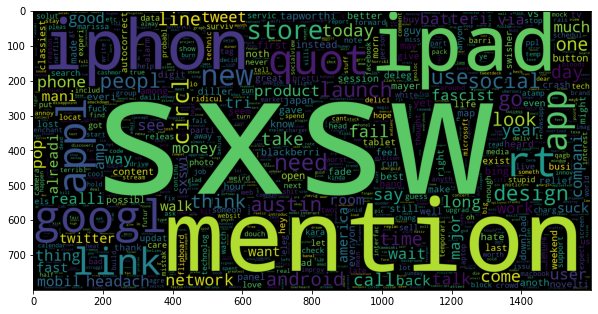

In [386]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
data_neg = data_neg['text']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_neg))
plt.imshow(wc)

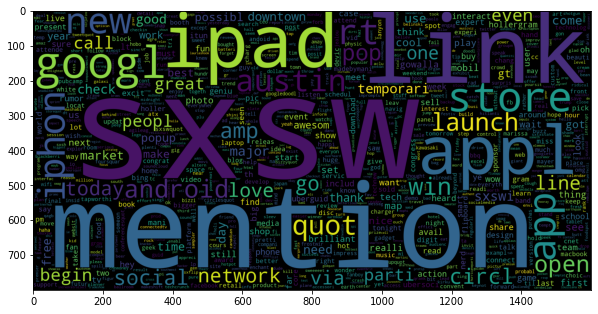

In [387]:
data_pos = data_pos['text']
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(data_pos))
plt.imshow(wc)

In [388]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])

sgd.fit(x_train, y_train)
y_pred = sgd.predict(x_test)
print(classification_report(y_test, y_pred))

                                    precision    recall  f1-score   support

                  Negative emotion       0.74      0.61      0.67        38
No emotion toward brand or product       0.43      0.50      0.46        24
                  Positive emotion       0.56      0.62      0.59        24

                          accuracy                           0.58        86
                         macro avg       0.58      0.58      0.57        86
                      weighted avg       0.60      0.58      0.59        86



In [397]:
vectoriser = TfidfVectorizer(ngram_range=(1,3), max_features=500000)
vectoriser.fit(x_train)
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

No. of feature_words:  25238


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [398]:
x_train = vectoriser.transform(x_train)
x_test  = vectoriser.transform(x_test)

In [391]:
x_train

<1624x13325 sparse matrix of type '<class 'numpy.float64'>'
	with 35648 stored elements in Compressed Sparse Row format>

In [392]:
def model_Evaluate(model):
  # Predict values for Test dataset
  y_pred = model.predict(x_test)
  # # Print the evaluation metrics for the dataset.
  print(classification_report(y_test, y_pred))
  # # Compute and plot the Confusion matrix
  # cf_matrix = confusion_matrix(y_test, y_pred)
  # categories = ['Negative','Positive','Neutral']
  # group_names = ['True Neg','False Pos', 'False Neg','True Pos']
  # group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
  # labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
  # labels = np.asarray(labels).reshape(2,2)
  # sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
  # xticklabels = categories, yticklabels = categories)
  # plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
  # plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
  # plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

In [399]:
BNBmodel = BernoulliNB()
BNBmodel.fit(x_train, y_train)
# model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(x_test)
print(classification_report(y_test, y_pred1))

                                    precision    recall  f1-score   support

                  Negative emotion       0.86      0.66      0.75        38
No emotion toward brand or product       0.55      0.46      0.50        24
                  Positive emotion       0.46      0.71      0.56        24

                          accuracy                           0.62        86
                         macro avg       0.62      0.61      0.60        86
                      weighted avg       0.66      0.62      0.62        86

